In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.reference.hydrostatic import generateHydroStatic
from sphMath.kernels import KernelType
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.integration import IntegrationSchemeType
from sphMath.enums import *

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

nx = 100
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3

gamma = 5/3
gamma = 1 + 2 / dim
initialStateLeft = sodInitialState(1, 1, 0)
initialStateRight = sodInitialState(0.1795, 0.25, 0)
ratio = 4
smoothIC = True
timeLimit = 0.15

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.symplecticEuler
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.OwenScheme

L = 2
band = 0
domain = buildDomainDescription(l = L, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
# particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

# dt = computeDT(particleSystem.systemState, CFL, solverConfig)
# timesteps = int(timeLimit / dt)


solverConfig['particle'] = {
    'nx': nx + 2 * 0,
    'dx': L/nx,
    'targetNeighbors': targetNeighbors,
    'band': band
}

In [3]:

r_inner = 0.9
r_outer = 1.0
dx = (r_outer - r_inner) / (nx)
print(dx)


domain = buildDomainDescription(r_outer * 1.1, 1, periodic = True, device = device, dtype = dtype)
dim = 1


# particles_l = sampleRegularParticles(nx + 20, buildDomainDescription(r_outer - r_inner + dx * 20, dim, periodic = False, device = device, dtype = dtype), targetNeighbors, jitter = 0.0)
particles_l = sampleRegularParticles(nx, buildDomainDescription(r_outer - r_inner, dim, periodic = True, device = device, dtype = dtype), targetNeighbors, jitter = 0.0)
particles_l = particles_l._replace(positions = particles_l.positions + r_inner + (r_outer-r_inner)/2)


print(particles_l.positions[1] - particles_l.positions[0])
print(particles_l.positions.shape)

0.0009999999999999998
True: dxs: [tensor(0.0010, dtype=torch.float64)], ns: [tensor(100, dtype=torch.int32)], nx: 100
tensor([0.0010], dtype=torch.float64)
torch.Size([100, 1])


In [4]:
nu = dim
gamma = 1 + 2 / nu


P_inner = 0.1
P_outer = 1.0

rho_outer = 0.01
rho_inner = (P_inner / P_outer)** (1/gamma) * rho_outer # Note that the paper disagrees with this and uses outer/inner. SPHERAL uses the flipped version
s = P_outer / rho_outer**gamma # paper uses inner/inner but these are equivalent here as the case is isentropic

print(f'r_inner = {r_inner}, r_outer = {r_outer}')
print(f'P_inner = {P_inner}, P_outer = {P_outer}')
print(f'rho_inner = {rho_inner}, rho_outer = {rho_outer}')
print(f's = {s}')

r_inner = 0.9, r_outer = 1.0
P_inner = 0.1, P_outer = 1.0
rho_inner = 0.004641588833612779, rho_outer = 0.01
s = 999999.9999999999


In [5]:
from kidder import KidderIsentropicCapsuleAnalyticSolution
kidderSolution = KidderIsentropicCapsuleAnalyticSolution(
    nu = nu,
    r0 = r_inner,
    r1 = r_outer,
    P0 = P_inner,
    P1 = P_outer,
    rho1 = rho_outer,
)

particles_l = particles_l._replace(
    densities = torch.tensor(kidderSolution.rho(0, torch.linalg.norm(particles_l.positions, dim = -1).cpu().numpy()), dtype = dtype, device = device),
    masses = torch.tensor(kidderSolution.rho(0, torch.linalg.norm(particles_l.positions, dim = -1).cpu().numpy()) * dx, dtype = dtype, device = device),
)

In [6]:
import numpy as np

In [7]:
t = 0
rInner = kidderSolution.rInner(t)
rOuter = kidderSolution.rOuter(t)

x = np.linspace(rInner, rOuter, 1000)
rho = kidderSolution.rho(t, x)
P = kidderSolution.P(t, x)
v = kidderSolution.vr(t, x)

pInner = kidderSolution.Pinner(t)
pOuter = kidderSolution.Pouter(t)

vInner = kidderSolution.vrInner(t)
vOuter = kidderSolution.vrOuter(t)

In [8]:
def kidderVelocity(t_, x):
    t = t_.cpu().numpy() if torch.is_tensor(t_) else t_
    r = torch.linalg.norm(x, dim = -1)
    # P = particles.pressures.cpu().numpy()
    # P = kidderSolution.P(t, r.cpu().numpy())
    Panalytic = kidderSolution.P(t, r.cpu().numpy())
    rhoAnalytic = kidderSolution.rho(t, r.cpu().numpy())

    uAnalytic = 1 / (solverConfig['fluid']['gamma'] - 1) * Panalytic / rhoAnalytic
    v = kidderSolution.vr(t, r.cpu().numpy())
    # print('Applying velocity, v = ', v, 't = ', t)
    return torch.tensor(v, dtype = x.dtype, device = x.device).view(-1,1)
def kidderDensity(t_, x):
    t = t_.cpu().numpy() if torch.is_tensor(t_) else t_
    r = torch.linalg.norm(x, dim = -1)
    # P = particles.pressures.cpu().numpy()
    # P = kidderSolution.P(t, r.cpu().numpy())
    Panalytic = kidderSolution.P(t, r.cpu().numpy())
    rhoAnalytic = kidderSolution.rho(t, r.cpu().numpy())

    uAnalytic = 1 / (solverConfig['fluid']['gamma'] - 1) * Panalytic / rhoAnalytic
    # print('Applying density')
    return torch.tensor(rhoAnalytic, dtype = x.dtype, device = x.device)
def kidderInternalEnergy(t_, x):
    t = t_.cpu().numpy() if torch.is_tensor(t_) else t_
    r = torch.linalg.norm(x, dim = -1)
    # P = particles.pressures.cpu().numpy()
    # P = kidderSolution.P(t, r.cpu().numpy())
    Panalytic = kidderSolution.P(t, r.cpu().numpy())
    rhoAnalytic = kidderSolution.rho(t, r.cpu().numpy())

    uAnalytic = 1 / (solverConfig['fluid']['gamma'] - 1) * Panalytic / rhoAnalytic
    # print('Applying internal energy')
    return torch.tensor(uAnalytic, dtype = x.dtype, device = x.device)
    
def kidderAcceleration(t_, x):
    t = t_.cpu().numpy() if torch.is_tensor(t_) else t_
    r = torch.linalg.norm(x, dim = -1)
    # P = particles.pressures.cpu().numpy()
    # P = kidderSolution.P(t, r.cpu().numpy())
    Panalytic = kidderSolution.P(t, r.cpu().numpy())
    rhoAnalytic = kidderSolution.rho(t, r.cpu().numpy())

    uAnalytic = 1 / (solverConfig['fluid']['gamma'] - 1) * Panalytic / rhoAnalytic
    v = kidderSolution.accelr(t, r.cpu().numpy())
    # print('Applying velocity, v = ', v, 't = ', t)
    return torch.tensor(v, dtype = x.dtype, device = x.device).view(-1,1)

In [ ]:
def interval_sdf(position, intervalBegin, intervalEnd):
    distToBegin = position - intervalBegin
    distToEnd = position - intervalEnd
    
    distToClosest = torch.where(
        torch.abs(distToBegin) < torch.abs(distToEnd),
        -distToBegin,
        distToEnd
    )
    return distToClosest[:,0]
def interval_sdf_gradient(position, intervalBegin, intervalEnd):
    distToBegin = position - intervalBegin
    distToEnd = position - intervalEnd
    distToClosest = torch.where(
        torch.abs(distToBegin) < torch.abs(distToEnd),
        distToBegin,
        distToEnd
    )
    
    direction = -torch.where(distToClosest == distToBegin, torch.sign(distToBegin), torch.sign(distToEnd))
    return direction

def buffer_sdf(position):
    dist = torch.ones_like(position[:,0])
    dist[:10] = -1
    dist[-10:] = -1
    # dist[:] = -1
    return dist
def buffer_sdf_gradient(position):
    dist = torch.ones_like(position[:,0])
    dist[:10] = 1
    dist[-10:] = -1
    return dist


domain_sdf = lambda x:( interval_sdf(x, -2, 2), interval_sdf_gradient(x, -2, 2) )
domain_sdf = lambda x: (buffer_sdf(x), buffer_sdf_gradient(x))
dt = 1e-1
regions = []
regions.append(buildRegion(
    sdf = domain_sdf,
    config = solverConfig,
    type = 'dirichlet',
    dirichletValues={
        'velocities': lambda x, mask, state, t, dt: kidderVelocity(t, x),
        'densities': lambda x, mask, state, t, dt: kidderDensity(t, x),
        'internalEnergies': lambda x, mask, state, t, dt: kidderInternalEnergy(t, x),
    },
    updateValues={
        'velocities': lambda x, mask, state, t, dt: kidderAcceleration(t , x),
        'positions': lambda x, mask, state, t, dt: kidderVelocity(t , x)
    }
))
solverConfig['regions'] = regions

True: dxs: [tensor(0.0200, dtype=torch.float64)], ns: [tensor(100, dtype=torch.int32)], nx: 100


In [10]:
totalArea = (rOuter - r_inner)
print(f'Total area = {totalArea}')  
print(dx)

Total area = 0.09999999999999998
0.0009999999999999998


In [11]:
# masses = torch.tensor(kidderSolution.rho(0, torch.linalg.norm(particles_l.positions, dim = -1).cpu().numpy()) * dx, dtype = dtype, device = device)

# simulationState.masses = masses
# print(f'total Mass: {simulationState.masses.sum()}')

# neighborhood, neighbors = evaluateNeighborhood(simulationState, domain, kernel, verletScale = solverConfig['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
# numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState, neighbors.neighbors, which = 'noghost')).rowEntries
# densities = computeDensity(simulationState, kernel, neighbors.get('noghost'), SupportScheme.Gather)

# # print(densities - kidderDensity(t, particles_l.positions))
# print(densities)
# print(kidderDensity(t, particles_l.positions) / densities)
# print(masses)
# # print(kidderSolution.rho(0, particles_l.positions))


In [12]:
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

Pinitial = torch.tensor(kidderSolution.P(t, torch.linalg.norm(particles_l.positions, dim = -1).cpu().numpy()), dtype = dtype, device = device)
# Pinitial[:10] = pInner
# Pinitial[-10:] = pOuter
print(Pinitial.shape)
A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
v_initial = torch.zeros_like(particles_l.positions)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    kinds = torch.zeros_like(particles_l.densities),
    materials = torch.zeros_like(particles_l.densities),
    UIDs = torch.arange(0, particles_l.densities.shape[0], dtype = torch.int64, device = device),
    UIDcounter= particles_l.densities.shape[0],

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities)
)

from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhood, filterNeighborhoodByKind, SupportScheme

neighborhood, neighbors = evaluateNeighborhood(simulationState, domain, kernel, verletScale = solverConfig['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState, neighbors.neighbors, which = 'noghost')).rowEntries
densities = computeDensity(simulationState, kernel, neighbors.get('noghost'), SupportScheme.Gather)

print(densities - kidderDensity(t, particles_l.positions))

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
simulationState.internalEnergies = u_

particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )


dt = computeTimestep(scheme, 1e-3, simulationState, solverConfig) / 10
print(dt)

torch.Size([100])
tensor([-1.1963e-03, -1.1085e-04, -1.2936e-06, -3.6311e-07, -3.4689e-07,
        -3.3182e-07, -3.1780e-07, -3.0473e-07, -2.9252e-07, -2.8109e-07,
        -2.7037e-07, -2.6031e-07, -2.5085e-07, -2.4193e-07, -2.3353e-07,
        -2.2559e-07, -2.1808e-07, -2.1097e-07, -2.0424e-07, -1.9785e-07,
        -1.9177e-07, -1.8600e-07, -1.8050e-07, -1.7527e-07, -1.7028e-07,
        -1.6551e-07, -1.6096e-07, -1.5661e-07, -1.5245e-07, -1.4846e-07,
        -1.4464e-07, -1.4098e-07, -1.3746e-07, -1.3409e-07, -1.3085e-07,
        -1.2773e-07, -1.2474e-07, -1.2185e-07, -1.1907e-07, -1.1639e-07,
        -1.1381e-07, -1.1132e-07, -1.0892e-07, -1.0660e-07, -1.0436e-07,
        -1.0219e-07, -1.0010e-07, -9.8075e-08, -9.6114e-08, -9.4216e-08,
        -9.2378e-08, -9.0597e-08, -8.8871e-08, -8.7197e-08, -8.5574e-08,
        -8.3998e-08, -8.2469e-08, -8.0984e-08, -7.9542e-08, -7.8140e-08,
        -7.6778e-08, -7.5454e-08, -7.4165e-08, -7.2912e-08, -7.1693e-08,
        -7.0506e-08, -6.9350e-08,

In [13]:


# # particles.densities, particles.pressures, particles.internalEnergies, particles.entropies, particles.soundspeeds = config['imposeState'](particles, domain, wrappedKernel, actualNeighbors, config, SPHSystem.t)

# def imposeKidder(particles, domain, wrappedKernel, actualNeighbors, config, t_): #(particles, domain, wrappedKernel, actualNeighbors, config):
#     t = t_.cpu().item() if isinstance(t_, torch.Tensor) else t_
#     rho = particles.densities
#     P = particles.pressures
#     u = particles.internalEnergies
#     c_s = particles.soundspeeds
#     A = particles.entropies

#     # print('Computing pressure')
#     x = particles.positions
#     r = torch.linalg.norm(x, dim = -1)
#     # P = particles.pressures.cpu().numpy()
#     # P = kidderSolution.P(t, r.cpu().numpy())
#     Panalytic = kidderSolution.P(t, r.cpu().numpy())
#     rhoAnalytic = kidderSolution.rho(t, r.cpu().numpy())
#     v = kidderSolution.vr(t, r.cpu().numpy())

#     uAnalytic = 1 / (solverConfig['gamma'] - 1) * Panalytic / rhoAnalytic

#     P[:10] = torch.tensor(Panalytic[:10], dtype = x.dtype, device = x.device)
#     P[-10:] = torch.tensor(Panalytic[-10:], dtype = x.dtype, device = x.device)
#     rInner = kidderSolution.rInner(t)
#     rOuter = kidderSolution.rOuter(t)
#     pInner = kidderSolution.Pinner(t)
#     pOuter = kidderSolution.Pouter(t)

#     vInner = kidderSolution.vrInner(t)
#     vOuter = kidderSolution.vrOuter(t)
#     # P[:10] = pInner
#     # P[-10:] = pOuter
#     u[:10] = torch.tensor(uAnalytic[:10], dtype = x.dtype, device = x.device)
#     u[-10:] = torch.tensor(uAnalytic[-10:], dtype = x.dtype, device = x.device)
#     rho[:10] = torch.tensor(rhoAnalytic[:10], dtype = x.dtype, device = x.device)
#     rho[-10:] = torch.tensor(rhoAnalytic[-10:], dtype = x.dtype, device = x.device)

#     # rho[:10] = kidderSolution.rho(t, rInner)
#     # rho[-10:] = kidderSolution.rho(t, rOuter)

#     uInner = 1 / (solverConfig['gamma'] - 1) * pInner / rho_inner
#     uOuter = 1 / (solverConfig['gamma'] - 1) * pOuter / rho_outer
#     # u[:10] = uInner
#     # u[-10:] = uOuter

#     c_sAnalytic = np.sqrt(uAnalytic * solverConfig['gamma'] * (solverConfig['gamma'] - 1))
#     c_s[:10] = torch.tensor(c_sAnalytic[:10], dtype = x.dtype, device = x.device)
#     c_s[-10:] = torch.tensor(c_sAnalytic[-10:], dtype = x.dtype, device = x.device)

    

#     # print(P.shape, x.shape)

#     particles.velocities[:10, 0] = torch.tensor(v[:10], dtype = x.dtype, device = x.device)
#     particles.velocities[-10:, 0] = torch.tensor(v[-10:], dtype = x.dtype, device = x.device)

#     return rho, P, u, A, c_s

# def imposeSolution(particles, domain, kernel, neighborhood, solverConfig, t_, dxdt, dvdt, dEdt, dudt, drhodt):
#     t = t_.cpu().item() if isinstance(t_, torch.Tensor) else t_
#     # print(f'Imposing solution {t}')
#     vInner = kidderSolution.vrInner(t)
#     vOuter = kidderSolution.vrOuter(t)
#     x = particles.positions
#     r = torch.linalg.norm(x, dim = -1)
#     v = kidderSolution.vr(t, r.cpu().numpy())
#     # t = t 
#     v_hat = kidderSolution.vr(t+ dt.cpu().item(), r.cpu().numpy())
#     dvdt[:10,:] = 0
#     dvdt[-10:,:] = 0
#     dxdt[:10,:] = torch.tensor(v[:10], dtype = dxdt.dtype, device = dxdt.device).unsqueeze(1)
#     dxdt[-10:,:] = torch.tensor(v[-10:], dtype = dxdt.dtype, device = dxdt.device).unsqueeze(1)
    
#     # print(v[:10], v[-10:])

#     dvdt[:10, 0] = -(particles.velocities[:10,0] - v_hat[:10]) / dt
#     dvdt[-10:, 0] = -(particles.velocities[-10:,0] - v_hat[-10:]) / dt

#     # particles.velocities[:10, 0] = torch.tensor(v[:10], dtype = x.dtype, device = x.device)
#     # particles.velocities[-10:, 0] = torch.tensor(v[-10:], dtype = x.dtype, device = x.device)

#     return dxdt, dvdt, dEdt, dudt, drhodt

# solverConfig['imposeState'] = imposeKidder
# solverConfig['imposeSolution'] = imposeSolution

timeLimit = 0.99 * kidderSolution.tau
# dt = computeDT(particleSystem.systemState, 0.05, solverConfig) / 10
timesteps = int(timeLimit / dt)
# simulationState = copy.deepcopy(particleSystem)

In [14]:
# print(dt*1.5)

In [15]:
simulationState = copy.deepcopy(particleSystem)
# priorStep = None

# simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep, verbose = False)

In [16]:

# simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = None)

In [17]:
# print(f'Positions: {particleSystem.systemState.positions.shape}, min: {particleSystem.systemState.positions.min()}, max: {particleSystem.systemState.positions.max()}')
# print(f'Supports: {particleSystem.systemState.supports.shape}, min: {particleSystem.systemState.supports.min()}, max: {particleSystem.systemState.supports.max()}')
# print(f'Densities: {particleSystem.systemState.densities.shape}, min: {particleSystem.systemState.densities.min()}, max: {particleSystem.systemState.densities.max()}')
# print(f'Velocities: {particleSystem.systemState.velocities.shape}, min: {particleSystem.systemState.velocities.min()}, max: {particleSystem.systemState.velocities.max()}')

# print(f'Internal Energies: {particleSystem.systemState.internalEnergies.shape}, min: {particleSystem.systemState.internalEnergies.min()}, max: {particleSystem.systemState.internalEnergies.max()}')
# print(f'Total Energies: {particleSystem.systemState.totalEnergies.shape}, min: {particleSystem.systemState.totalEnergies.min()}, max: {particleSystem.systemState.totalEnergies.max()}')
# print(f'Entropies: {particleSystem.systemState.entropies.shape}, min: {particleSystem.systemState.entropies.min()}, max: {particleSystem.systemState.entropies.max()}')
# print(f'Pressures: {particleSystem.systemState.pressures.shape}, min: {particleSystem.systemState.pressures.min()}, max: {particleSystem.systemState.pressures.max()}')
# print(f'Sound Speeds: {particleSystem.systemState.soundspeeds.shape}, min: {particleSystem.systemState.soundspeeds.min()}, max: {particleSystem.systemState.soundspeeds.max()}')

# print(f'Alphas: {particleSystem.systemState.alphas.shape}, min: {particleSystem.systemState.alphas.min()}, max: {particleSystem.systemState.alphas.max()}')
# print(f'Alpha0s: {particleSystem.systemState.alpha0s.shape}, min: {particleSystem.systemState.alpha0s.min()}, max: {particleSystem.systemState.alpha0s.max()}')


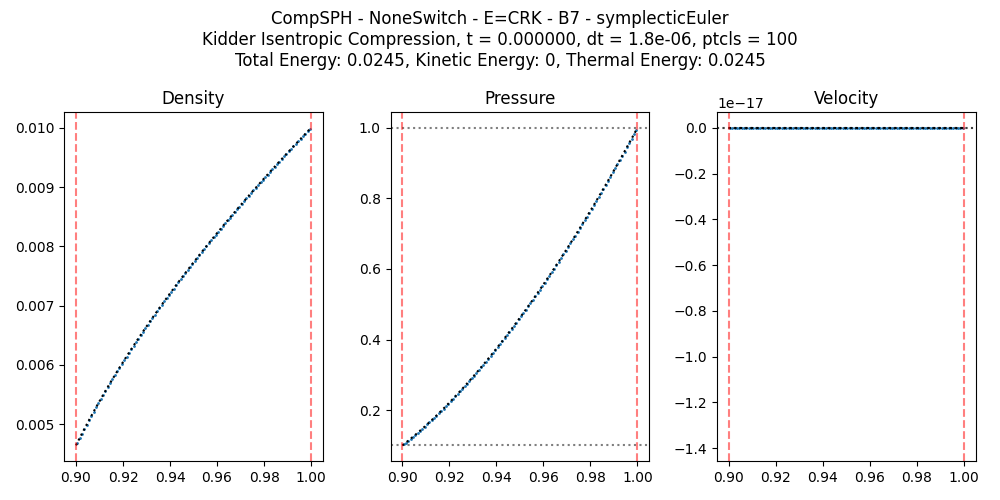

In [18]:
fig, axis = plt.subplots(1, 3, figsize = (10, 5), squeeze=False)

def setupPlot(fig, axis, t):
    # print(t)
    rInner = kidderSolution.rInner(t)
    rOuter = kidderSolution.rOuter(t)

    x = np.linspace(rInner, rOuter, 1000)
    rho = kidderSolution.rho(t, x)
    P = kidderSolution.P(t, x)
    # v = kidderSolution.vr(t+660*dt.cpu().item(), x)
    v = kidderSolution.vr(t, x)

    pInner = kidderSolution.Pinner(t)
    pOuter = kidderSolution.Pouter(t)

    vInner = kidderSolution.vrInner(t)
    vOuter = kidderSolution.vrOuter(t)

    axis[0,0].plot(x, rho, 'black', ls = ':', label = 'Analytic')
    axis[0,1].axhline(pInner, color = 'black', ls = ':', alpha = 0.5)
    axis[0,1].axhline(pOuter, color = 'black', ls = ':', alpha = 0.5)
    axis[0,1].plot(x, P, 'black', ls = ':', label = 'Analytic')
    axis[0,2].plot(x, v, 'black', ls = ':', label = 'Analytic')
    axis[0,2].axhline(vInner, color = 'black', ls = ':', alpha = 0.5)
    axis[0,2].axhline(vOuter, color = 'black', ls = ':', alpha = 0.5)

    axis[0,0].set_title('Density')
    axis[0,1].set_title('Pressure')
    axis[0,2].set_title('Velocity')
    
    for ax in axis[0]:
        ax.axvline(rInner, color = 'r', ls = '--', alpha = 0.5)
        ax.axvline(rOuter, color = 'r', ls = '--', alpha = 0.5)
# setupPlot(fig, axis, 0)


# neighborhood, neighbors = evaluateNeighborhood(simulationState.systemState, domain, kernel, verletScale = solverConfig['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
# numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState.systemState, neighbors.neighbors, which = 'noghost')).rowEntries
# densities = computeDensity(simulationState.systemState, kernel, neighbors.get('noghost'), SupportScheme.Gather)


kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy
setupPlot(fig, axis, (simulationState.t).item() if isinstance(simulationState.t, torch.Tensor) else simulationState.t)
axis[0,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.densities.cpu().numpy(), s = 1)
axis[0,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.pressures.cpu().numpy(), s = 1)
axis[0,2].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.velocities.cpu().numpy(), s = 1)
fig.suptitle(f'{solverConfig["schemeName"]}\nKidder Isentropic Compression, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
# fig.canvas.draw()
# fig.canvas.flush_events()

fig.tight_layout()


In [19]:

import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

imagePrefix = './images/Kidder_1D/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

Current dt: 1.795955686590576e-06
Plot Interval: 40
export Steps: 11137
New dt: 1.7958157493041213e-06


In [20]:

states = []
priorStep = None
plotInterval = 100
# timesteps = 20


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)

    simulationState.systemState.velocities
    t_ = simulationState.t.cpu().item()
    rInner = kidderSolution.rInner(t_)
    rOuter = kidderSolution.rOuter(t_)
    v = kidderSolution.vr(t_, torch.linalg.norm(simulationState.systemState.positions, dim = -1).cpu().numpy())
    simulationState.systemState.velocities[:10, 0] = torch.tensor(v[:10], dtype = simulationState.systemState.velocities.dtype, device = simulationState.systemState.velocities.device)
    simulationState.systemState.velocities[-10:, 0] = torch.tensor(v[-10:], dtype = simulationState.systemState.velocities.dtype, device = simulationState.systemState.velocities.device)

    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    states.append(copy.deepcopy(simulationState.to(device = 'cpu')))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })
    if (i % plotInterval == 0 and i > 0) or i == timesteps - 1:
        axis[0,0].cla()
        axis[0,1].cla()
        axis[0,2].cla()

        setupPlot(fig, axis, simulationState.t.item())
        axis[0,0].scatter(simulationState.systemState.positions.cpu().numpy(), currentState[1][0].densities.cpu().numpy(), s = 1)
        axis[0,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.pressures.cpu().numpy(), s = 1)
        axis[0,2].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.velocities.cpu().numpy(), s = 1)
        fig.suptitle(f'{solverConfig["schemeName"]}\nKidder Isentropic Compression, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    
    if simulationState.t >= 0.02:
        break


  0%|          | 0/15661 [00:00<?, ?it/s]

In [21]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'kidderIsentropic',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!
